In [1]:
import pandas as pd
import xgboost as xgb
import pickle

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from scipy.stats import norm

%run analysis_utils.py
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_pickle('../prepare_higgs/df_ML.pkl')

bkg = df.query('y==0')
sig = df.query('y==1')

data = pd.concat([bkg,sig],ignore_index=True)
data_small = data.sample(frac=0.01)

print(len(data_small))

110000


In [3]:
columns = ['jet_1_pt','jet_2_pt','jet_3_pt','jet_4_pt','m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb','missing_energy_magnitude']

# columns = ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb','missing_energy_magnitude']

In [4]:
# traindata,testdata,ytrain,ytest = train_test_split(data, data['y'], test_size=0.5)
traindata,testdata,ytrain,ytest = train_test_split(data_small, data_small['y'], test_size=0.5)

In [ ]:
plot_distr(df, column=columns, figsize=(40,40), bins=100)

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params_def = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist',
    'scale_pos_weight': 10}

In [6]:
def optimize_params(dtrain,par):
    %run analysis_utils.py
    gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(2, 10, 2)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(0, 12, 2)]},
          }
    par['max_depth'],par['min_child_weight'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    
    gs_dict = {'first_par': {'name': 'subsample', 'par_values': [i/10. for i in range(4, 10)]},
           'second_par': {'name': 'colsample_bytree', 'par_values': [i/10. for i in range(8, 10)]},
          }
    par['subsample'],par['colsample_bytree'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'gamma', 'par_values': [i/10. for i in range(0, 11)]}} 
    par['gamma'],_ = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'eta', 'par_values': [0.1, 0.05, 0.01, 0.005, 0.001]}}
    par['eta'],n = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    return n

In [7]:
dtrain = xgb.DMatrix(data=np.asarray(traindata[columns]), label=ytrain, feature_names=columns)
n_round = optimize_params(dtrain,params_def)
model_cent_integr = xgb.train(params_def, dtrain,num_boost_round=num_rounds) 

/home/pfecchio/.local_pip/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


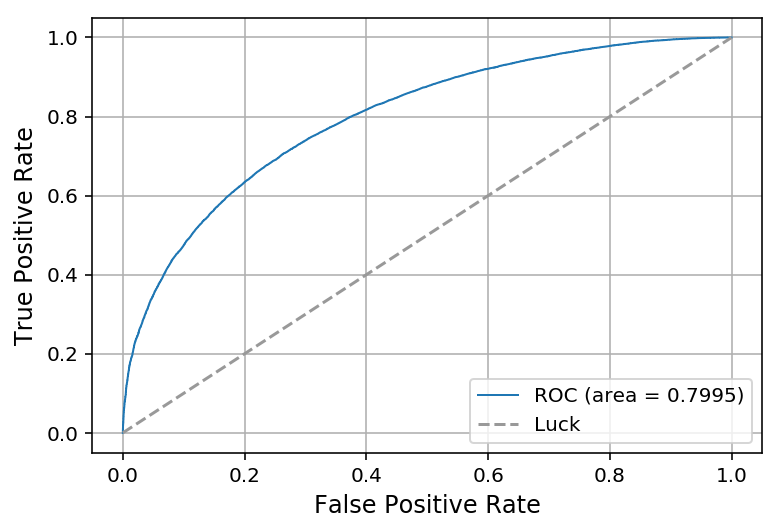

In [8]:
dtest = xgb.DMatrix(data=testdata[columns])
y_pred = model_cent_integr.predict(dtest,output_margin=True)
plot_roc(ytest,y_pred)

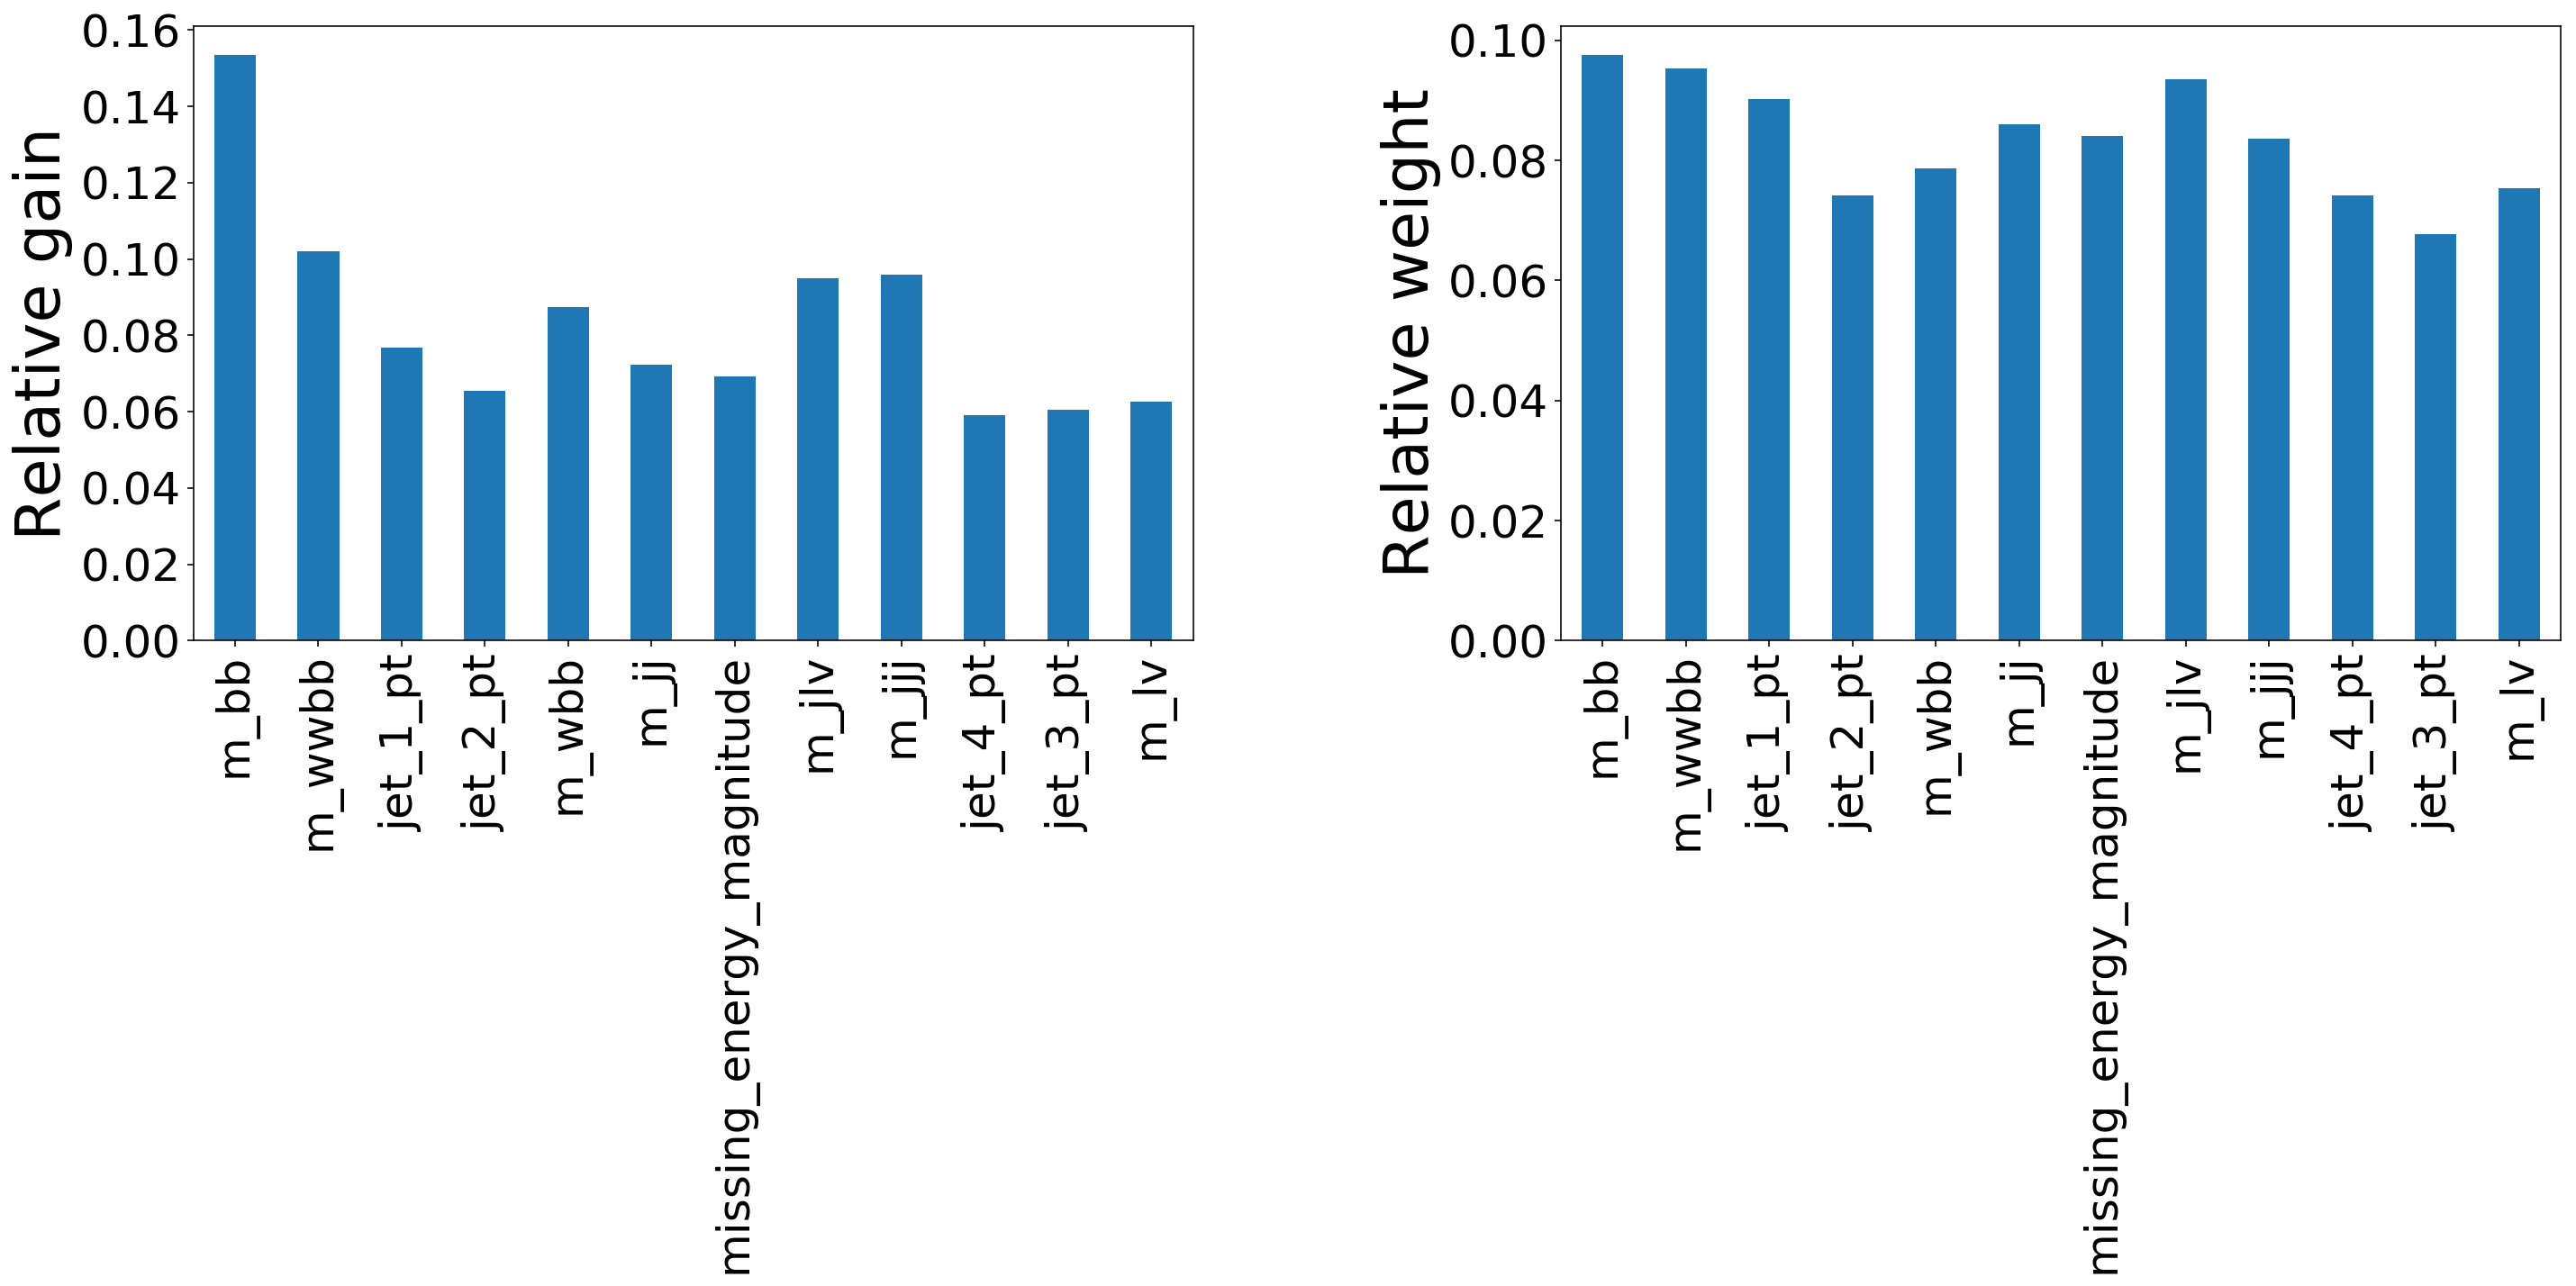

In [9]:
plot_feature_imp(model_cent_integr,['gain','weight'])